In this notebook we check whether T1236C, T2677G and T3435C are in positions of conserved low/high MFE (and therefore perhaps affect co-translational folding). We plot the results. 

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from Utils_MDR1 import *

## Functions

In [111]:
''' 
Takes the df that contains the z-score per each cds position in the MDR1 gene, and add two 
boolian columns that indicate whether the position is a position with significantly low or high z-score. 

Positions with significantly low[high] z-scores are positions that -
1. Have a negative[positive] z-score. 
2. Have a p-value smaller than 0.1. 
3. Are in valid positions ("good_position" == True) 
'''
def get_significant_positions(zscores_df: pd.DataFrame) -> pd.DataFrame:
    
    low_z = zscores_df["z-score"] < 0 #z-scores that are below the mean
    high_z = zscores_df["z-score"] > 0 #z-scores that are below the mean
    low_p = zscores_df["corrected p-value"] < 0.1 #z-scores with a p-value lower than 0.1 (could be high or low z-scores)
    good_pos = zscores_df["good_position"] == True #only z-scores at valid positions
    
    zscores_df["significantly_low_mfe"] = low_z & low_p & good_pos
    zscores_df["significantly_high_mfe"] = high_z & low_p & good_pos
    
    return(zscores_df)

In [119]:
'''
Plots the mfe profile of the original MDR1 gene and the mean mfe profile for the vertical 
and column permutations. Also plots dots where the mfe of the original gene is significantly low or high 
compared to both randomizations.

"cds_pos": the cds_position of the variant, 0-based
"mfe_scores_original": mfe scores of the entire CDS, a single score per position
"mfe_scores_vertical": mfe scores of the entire CDS, mean of vertical randomizations. 
"mfe_scores_column": mfe scores of the entire CDS, mean of column randomizations. 
"low_positions": the CDS positions with extremely low MFE respective to both vertical and column randomizations.
"high_positions": the CDS positions with extremely high MFE respective to both vertical and column randomizations.

'''

def plot(variant_name:str, cds_pos: int, mfe_scores_original: np.array, mfe_scores_vertical: np.array, mfe_scores_column: np.array, low_positions: np.array, high_positions: np.array, z_scores_vertical: pd.DataFrame, z_scores_column: pd.DataFrame) -> None:
    
    num_positions = mfe_scores_original.shape[0] #total nu,ber of positions in the CDS
    
    plt.plot(np.arange(num_positions), mfe_scores_original, c = "purple", label = "Original")
    plt.plot(np.arange(num_positions), mfe_scores_vertical, c = "brown", label = "Mean of VP")
    plt.plot(np.arange(num_positions), mfe_scores_column, c = "orange", label = "Mean of HP")

    maxi = max(max(mfe_scores_original), max(mfe_scores_vertical), max(mfe_scores_column))
    plt.axvline(x = cds_pos, color = 'royalblue', label = 'position of variant')

    #Plot dots above the locations where vector2 equals 1
    dot_height = maxi + 5  # Adjust the height of the dots
    plt.scatter(low_positions, [dot_height] * len(low_positions), color='red', label = "consevred low MFE (slow)", s = 1.5)
    plt.scatter(high_positions, [dot_height] * len(high_positions), color='green', label = "conserved high MFE (fast)", s = 1.5)

    plt.legend(framealpha=0.2)
    plt.xlim([cds_pos - 100, cds_pos + 100])
    
    pval_ver = np.round(z_scores_vertical.loc[cds_pos]["corrected p-value"],2)
    pval_col = np.round(z_scores_column.loc[cds_pos]["corrected p-value"],2)

    plt.title(f"{variant_name} (VP p-value = {pval_ver}, HP p-value = {pval_col})")
#    plt.title(f"{variant_name}")

    plt.xlabel("CDS position")
    plt.ylabel("MFE score")

    plt.savefig(f'../Figures/co_trans/{variant_name}_co_trans.png', bbox_inches = "tight", dpi=500)


## Main

In [113]:
gene = "ENSG00000085563" #MDR1

In [114]:
''' Get the mfe profiles of the original MDR1 gene and the permutations '''
original = pd.read_pickle(f"../Results/mfe/mfe_scores/original/{gene}.pickle.gz")
column = pd.read_pickle(f"../Results/mfe/mfe_scores/column/{gene}.pickle.gz").mean(axis = 0)
vertical = pd.read_pickle(f"../Results/mfe/mfe_scores/vertical/{gene}.pickle.gz").mean(axis = 0)


In [115]:
''' Get the positions with the significantly low/high z-scores '''

#z-scores of all MDR1 cds positions
z_scores_vertical = pd.read_pickle(f"../Results/mfe/z_scores/{gene}_vertical.pickle")
z_scores_column = pd.read_pickle(f"../Results/mfe/z_scores/{gene}_column.pickle")

#add to each df two boolian columns indicating wether the position has significantly (p<0.1) low or high mfe
z_scores_vertical = get_significant_positions(z_scores_vertical)
z_scores_column = get_significant_positions(z_scores_column)

#get the positions for which there is concensus among vertical and column methods
low_mfe = (z_scores_vertical["significantly_low_mfe"] & z_scores_column["significantly_low_mfe"]).replace({True: 1, False: 0})
high_mfe = (z_scores_vertical["significantly_high_mfe"] & z_scores_column["significantly_high_mfe"]).replace({True: 1, False: 0})

low_positions = np.where(low_mfe == 1)[0] #the CDS positions with significantly low z-scores
high_positions = np.where(high_mfe == 1)[0]#the CDS positions with significantly high z-scores



### T1236C

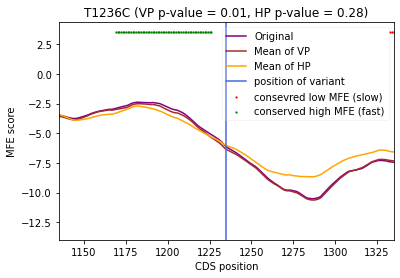

In [120]:
variant_name = variant_info[1]["variant_name"] 
cds_pos = variant_info[1]["cds_position"] - 1 #0-based
plot(variant_name, cds_pos, original, vertical, column, low_positions, high_positions, z_scores_vertical, z_scores_column)


### T2677G

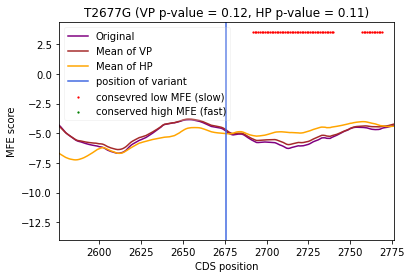

In [121]:
variant_name = variant_info[2]["variant_name"] 
cds_pos = variant_info[2]["cds_position"] - 1 #0-based
plot(variant_name, cds_pos, original, vertical, column, low_positions, high_positions, z_scores_vertical, z_scores_column)


### T3435C

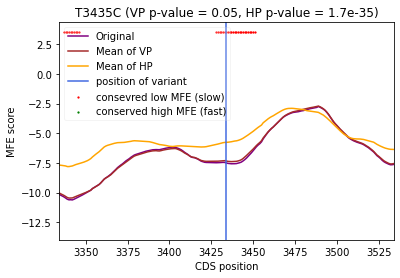

In [118]:
variant_name = variant_info[3]["variant_name"] 
cds_pos = variant_info[3]["cds_position"] - 1 #0-based
plot(variant_name, cds_pos, original, vertical, column, low_positions, high_positions, z_scores_vertical, z_scores_column)
